# Plots for the $\beta$ -Pic b planet

## Import the necessary packages

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import orbitize
from orbitize import read_input
from orbitize.system import seppa2radec
from astropy.time import Time
from lampe.plots import nice_rc, corner
from prior import prior_distributions
from lampe.inference import MetropolisHastings

## Vizualise the observations

In [6]:
data_set = read_input.read_file('{}/betaPic.csv'.format(orbitize.DATADIR))
data_set = data_set[:-1]

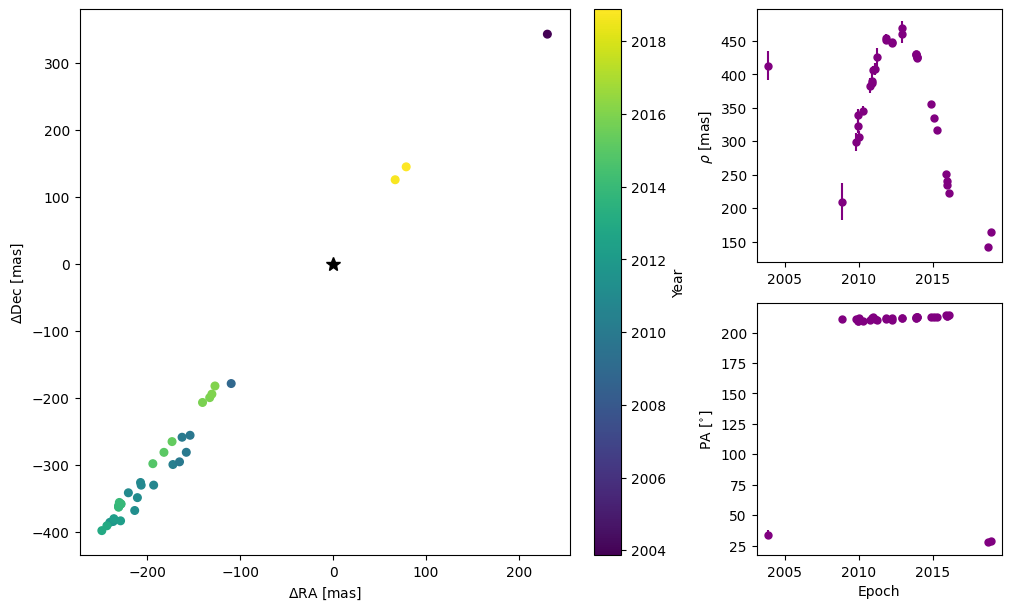

In [7]:
epochs = data_set['epoch'].data
sep = data_set['quant1'].data
pa = data_set['quant2'].data
serr = data_set['quant1_err'].data
perr= data_set['quant2_err'].data

ra, dec = seppa2radec(sep,pa)
rerr, derr = seppa2radec(serr, perr)

fig = plt.figure(figsize=(10, 6), constrained_layout=True)
axs = fig.subplot_mosaic([['Left', 'TopRight'], ['Left', 'BottomRight']], gridspec_kw={'width_ratios': [2, 1]})

axs['Left'].set_xlabel('$\\Delta$RA [mas]')
axs['Left'].set_ylabel('$\\Delta$Dec [mas]')
axs['BottomRight'].set_xlabel('Epoch')
axs['BottomRight'].set_ylabel('PA [$^{{\\circ}}$]')
axs['TopRight'].set_ylabel(r'$\rho$ [mas]')

axs['TopRight'].errorbar(Time(epochs, format='mjd').decimalyear, sep, yerr=serr, ms=5, fmt='o', color='purple')
axs['BottomRight'].errorbar(Time(epochs, format='mjd').decimalyear, pa, yerr=perr, ms=5, fmt='o', color='purple')

sc = axs['Left'].scatter(ra, dec, c=Time(epochs, format='mjd').decimalyear, cmap='viridis', s=30, marker='o')
cbar = plt.colorbar(sc, ax=axs['Left'])
cbar.set_label('Year')

axs['Left'].plot(0,0,marker="*",color='black',markersize=10)

plt.show()

## Corner plots

First load the observation in the same format as the data generated by the simulator

In [9]:
quant1 = data_set["quant1"].data
quant2 = data_set["quant2"].data

ra, dec = seppa2radec(quant1, quant2)

x_star = torch.empty(2 * len(ra), dtype=torch.float32)
x_star[0::2] = torch.tensor(ra, dtype=torch.float32)
x_star[1::2] = torch.tensor(dec, dtype=torch.float32)

x_star = x_star.clone().detach()

Corner plot function

In [30]:
def corner_plot(samples, estimator_name, name, save = False):
    plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

    LOWER = torch.tensor([10.0,10e-8, 0.0, 0.0, 0.0, 0.0, 55.91, 0.9])
    UPPER = torch.tensor([10**2, 0.99, 180.0, 360.0, 360.0, 1.0, 57.99, 1.54])

    LABELS = [r'$a$', r'$e$', r'$i$',
            r'$\omega$', r'$\Omega$',
            r'$\tau$', r'$\pi$', r'$M_T$']

    fig = corner(
        samples,
        domain=(LOWER, UPPER),
        labels=LABELS,
        legend=r'$p_\phi(\theta | x^*)$',
        smooth=2
    )
    plt.show()
    
    if save:
        plt.savefig(f"Plots/beta_pic/{estimator_name}/{name}", format='svg')


### NPE

In [10]:
npe_estimator = torch.load('Models/npe_model_new.pth').cuda()

In [14]:
with torch.no_grad():
    samples = npe_estimator.flow(x_star.cuda()).sample((2**14,)).cpu()

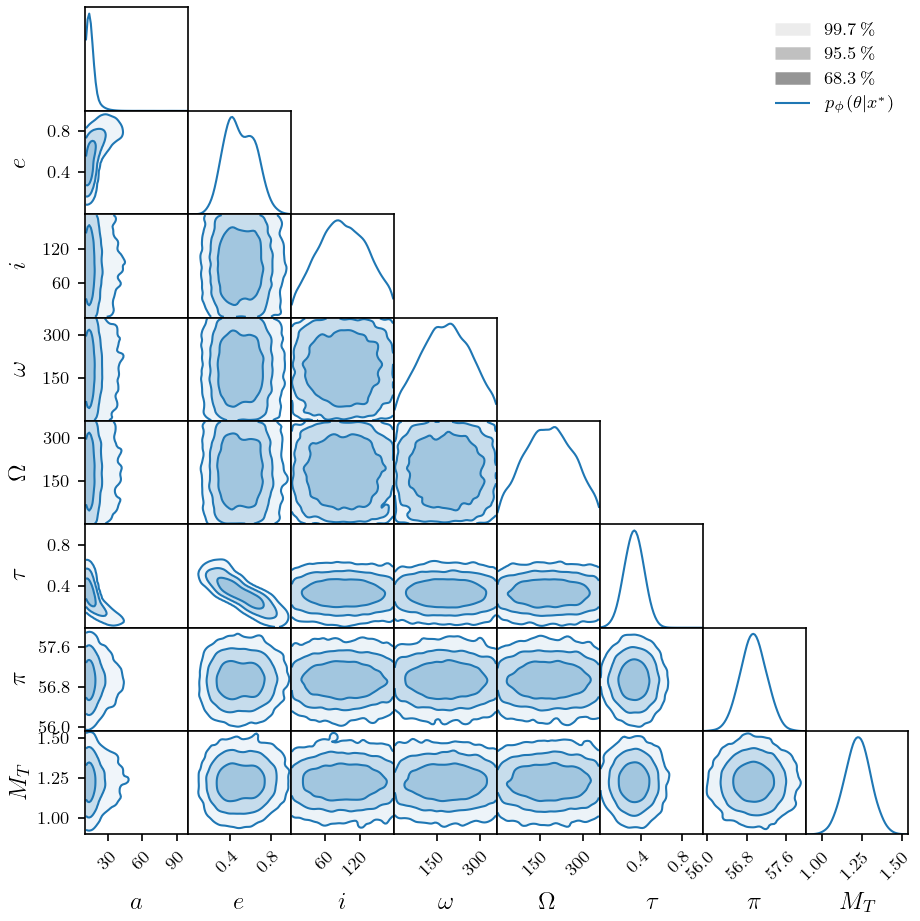

<Figure size 960x720 with 0 Axes>

In [17]:
corner_plot(samples, '', '', save=False)

### NRE

In [27]:
nre_estimator = torch.load('Models/nre_model.pth', map_location=torch.device('cpu'))

In [32]:
prior = prior_distributions(log_uniform_lower = torch.tensor(10.0), 
                            log_uniform_upper = torch.tensor(10**4),
                            uniform_lower = torch.tensor([10e-8, 0.0, 0.0, 0.0, 0.0]), 
                            uniform_upper = torch.tensor([0.99, 180.0, 360.0, 360.0, 1.0]),
                            gaussian_mean = torch.tensor([56.95, 1.22]), 
                            gaussian_std = torch.tensor([0.26, 0.08]))

with torch.no_grad():
    theta_0 = prior.sample((2048,)) # 1024 concurrent Markov chains
    log_p = lambda theta: nre_estimator(theta, x_star) + prior.log_prob(theta)  # p(theta | x) = r(theta, x) p(theta)

    sampler = MetropolisHastings(theta_0, log_f=log_p, sigma=0.5)
    samples = torch.cat(list(sampler(20000, burn=5000, step=40)))

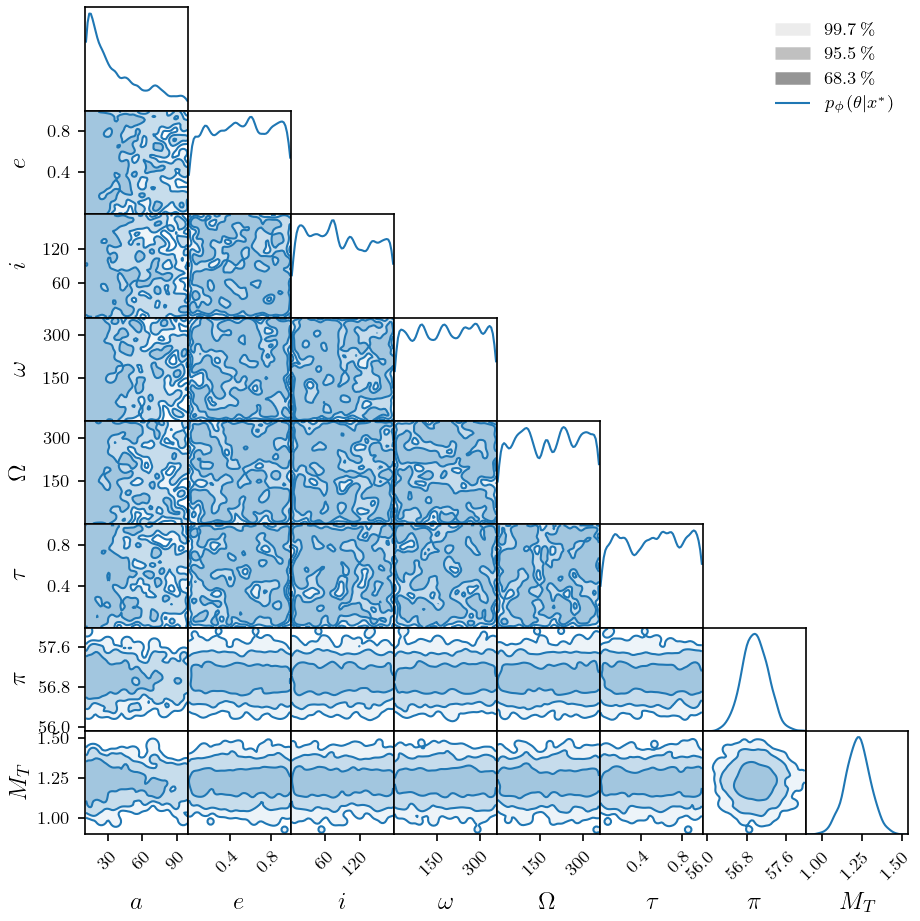

In [33]:
corner_plot(samples, '', '', save=False)

### FMPE

In [12]:
fmpe_estimator = torch.load('Models/fmpe_model.pth').cuda()

In [34]:
with torch.no_grad():
    samples = fmpe_estimator.flow(x_star.cuda()).sample((2**14,)).cpu()

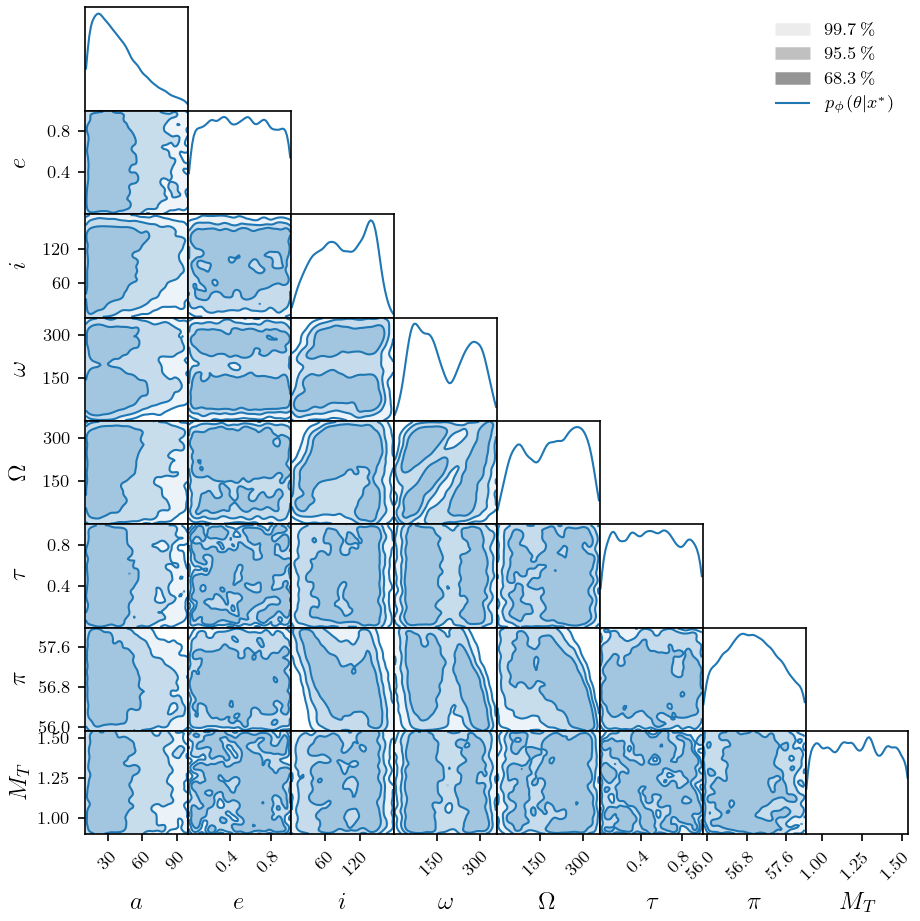

In [35]:
corner_plot(samples, '', '', save=False)